In [198]:
import pandas as pd
import numpy as np
import preprocessing
import lstm_model
import lin_reg
import plots
import stock_data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

data = pd.read_csv('apple_excel.csv')
#data.head()




In [199]:
def drop_cols(data):
    #removing unncessary columns
    stocks=pd.DataFrame()
    stocks=data[['Open','Close','Volume']].copy()

    stocks.insert(0, 'Item', range(0, 0 + len(stocks)))

    return stocks

In [200]:
stocks = preprocessing.drop_cols(data)

print(stocks.head())

print(stocks.tail())

   Item  Open  Close    Volume
0     0  9.54   9.67  28462622
1     1  9.71   9.63  17109572
2     2  9.54   9.36  25333632
3     3  9.39   9.34  27085710
4     4  9.39   9.59  19958536
      Item    Open   Close    Volume
3017  3017  163.92  165.07  69023941
3018  3018  165.02  167.40  67723833
3019  3019  168.76  167.23  67929814
3020  3020  168.91  166.42  87227768
3021  3021  166.46  161.79  84882424


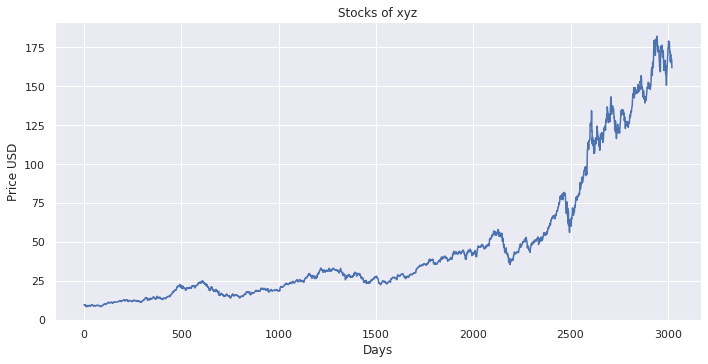

In [201]:
#basic stock plot
plots.plot_stocks(stocks)

In [202]:
from sklearn.preprocessing import MinMaxScaler

def normalize(data):
   
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler()
    num_col = list(data.columns)
    num_col.remove('Item')
    data[num_col] = scaler.fit_transform(data[num_col])

    return data


   Item      Open     Close    Volume
0     0  0.007284  0.007201  0.085122
1     1  0.008259  0.006970  0.050972
2     2  0.007284  0.005415  0.075710
3     3  0.006423  0.005300  0.080980
4     4  0.006423  0.006740  0.059542


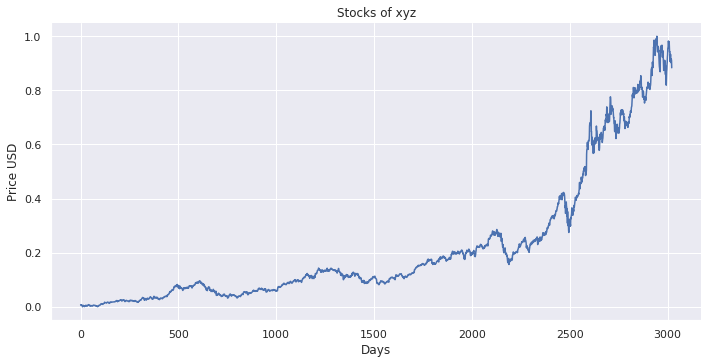

In [203]:

stocks = normalize(stocks)
print(stocks.head())

plots.plot_stocks(stocks)


In [204]:
stocks.to_csv('apple_processed.csv',index= False)

In [205]:

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import math

stocks = pd.read_csv('apple_processed.csv')
stocks.head()

,Item,Open,Close,Volume
0,0,0.007284,0.007201,0.085122
1,1,0.008259,0.006970,0.050972
2,2,0.007284,0.005415,0.075710
3,3,0.006423,0.005300,0.080980
4,4,0.006423,0.006740,0.059542


In [206]:
X_train, X_test, y_train, y_test, label_range= stock_data.train_test_split_linear_regression(stocks)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)


x_train (2071, 1)
y_train (2071, 1)
x_test (951, 1)
y_test (951, 1)


In [207]:
model = lin_reg.build_model(X_train,y_train)

In [208]:
predictions = lin_reg.predict_prices(model,X_test, label_range)

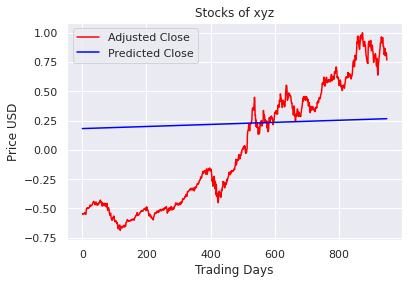

In [209]:


def plot_predstock(actual, pred, title='Stocks of xyz', y_label='Price USD', x_label='Trading Days'):
    
    

    # Plot actual and predicted close values

    plt.plot(actual, 'red', label='Adjusted Close')
    plt.plot(pred, 'blue', label='Predicted Close')

    # Set title, label
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.title(title)
    plt.legend(loc='upper left')

    plt.show()

plot_predstock(y_test,predictions)

In [210]:
trainScore = mean_squared_error(X_train, y_train)
print(trainScore)

testScore = mean_squared_error(predictions, y_test)
print(trainScore)

0.3410719086910154
0.3410719086910154


In [211]:



from keras.models import Sequential
from keras.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

from sklearn.model_selection import StratifiedKFold

import lstm_model, time 

import plots as vs
import stock_data as sd
import lin_reg
import stock_data 

stocks = pd.read_csv('apple_processed.csv')
stocks_data = stocks.drop(['Item'], axis =1)
stocks_data.head()

,Open,Close,Volume
0,0.007284,0.007201,0.085122
1,0.008259,0.006970,0.050972
2,0.007284,0.005415,0.075710
3,0.006423,0.005300,0.080980
4,0.006423,0.006740,0.059542


In [212]:
def train_test_split_lstm(stocks, prediction_time=1, test_data_size=450, unroll_length=50):
    # training data
    test_data_cut = test_data_size + unroll_length + 1

    x_train = stocks[0:-prediction_time - test_data_cut].values
    y_train = stocks[prediction_time:-test_data_cut]['Close'].values

    # test data
    x_test = stocks[0 - test_data_cut:-prediction_time].values
    y_test = stocks[prediction_time - test_data_cut:]['Close'].values

    return x_train, x_test, y_train, y_test


In [213]:
X_train, X_test,y_train, y_test = train_test_split_lstm(stocks_data, 5)

unroll_length = 50
X_train = sd.unroll(X_train, unroll_length)
X_test = sd.unroll(X_test, unroll_length)
y_train = y_train[-X_train.shape[0]:]
y_test = y_test[-X_test.shape[0]:]

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (2466, 50, 3)
y_train (2466,)
x_test (446, 50, 3)
y_test (446,)


In [214]:
# build basic lstm model
model = lstm_model.basic_model(ip_dim = X_train.shape[-1],op_dim = unroll_length, return_sequences=True)

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

compilation time :  0.004109382629394531


In [215]:
model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_split=0.05)

74/74 [==============================] - 15s 136ms/step - loss: 0.0010 - val_loss: 9.7913e-04


In [216]:
predictions = model.predict(X_test)

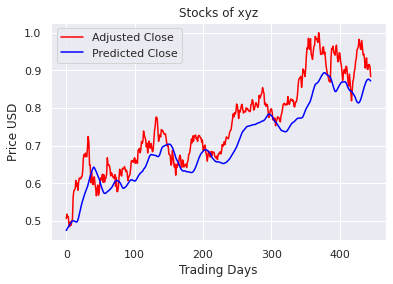

In [217]:
plot_predstock(y_test,predictions)


In [218]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00012575 MSE (0.01121394 RMSE)
Test Score: 0.00420683 MSE (0.06486009 RMSE)


In [227]:
# Set up hyperparameters
batch_size = 100
epochs = 2

# build improved lstm model
model = lstm_model.build_improved_model( X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

compilation time :  0.014529705047607422


In [228]:
model.fit(X_train, 
          y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.05
         )

Epoch 1/2
24/24 - 22s - loss: 0.0024 - val_loss: 0.0014 - 22s/epoch - 922ms/step
Epoch 2/2
24/24 - 5s - loss: 2.4530e-04 - val_loss: 0.0011 - 5s/epoch - 211ms/step


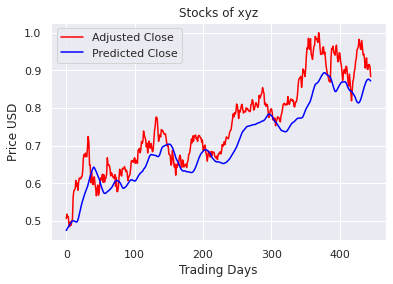

In [229]:
plot_predstock(y_test,predictions)


In [230]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print(trainScore)

testScore = model.evaluate(X_test, y_test, verbose=0)
print(testScore)

0.0001434119330951944
0.0034942899364978075
